In [1]:
%%capture
!pip install keras-tuner --upgrade
!pip install yfinance
!pip install yahoofinancials

# Step #1 Load the Data

In [2]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization
import yfinance as yf
from yahoofinancials import YahooFinancials
# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))



Tensorflow Version: 2.8.0
Num GPUs: 1


In [3]:
df = yf.download('AAPL', 
                      start='2015-01-01', 
                      end='2021-06-12', 
                      progress=False,
).reset_index()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.678249,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.983021,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.985279,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.321615,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,25.256098,237458000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1622 entries, 0 to 1621
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1622 non-null   datetime64[ns]
 1   Open       1622 non-null   float64       
 2   High       1622 non-null   float64       
 3   Low        1622 non-null   float64       
 4   Close      1622 non-null   float64       
 5   Adj Close  1622 non-null   float64       
 6   Volume     1622 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 88.8 KB


# Naive persistent model

In [5]:
act=df.loc[-365::,'Close'].values
shift= df.loc[-365::,'Close'].shift().fillna(df.loc[-365::,'Close'].mean()).values

In [6]:
mean_absolute_error(shift,act)

0.760372761790165

In [7]:
len(act)

1622

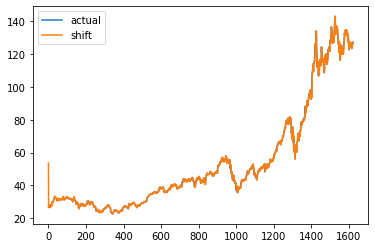

In [8]:
plt.plot(act,label='actual')

plt.plot(shift,label='shift')
plt.legend()

# Step #3 Preprocessing and Feature Selection

In [9]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
# add more features
# Adding Month and Year in separate columns
train_df['Month'] = train_df['Date'].dt.month
train_df['Day'] =train_df['Date'].dt.day
train_df['Week'] =train_df['Date'].dt.week

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


,Date,Open,High,Low,Close,Adj Close,Volume,Month,Day,Week
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.678249,212818400,1,2,1
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.983021,257142000,1,5,2
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.985279,263188400,1,6,2
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.321615,160423600,1,7,2
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,25.256098,237458000,1,8,2


In [10]:
train_df=train_df.iloc[:,1::]#remove date column

In [11]:
train_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Month,Day,Week
1617,126.169998,126.320000,124.830002,125.900002,125.184792,71057600,6,7,23
1618,126.599998,128.460007,126.209999,126.739998,126.020012,74403800,6,8,23
1619,127.209999,127.750000,126.519997,127.129997,126.407799,56877900,6,9,23
1620,127.019997,128.190002,125.940002,126.110001,125.393600,71186400,6,10,23
1621,126.529999,127.440002,126.099998,127.349998,126.626549,53522400,6,11,23


In [12]:
# Get the number of rows in the data
nrows = train_df.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(train_df)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_High = pd.DataFrame(train_df['High'])
np_High_scaled = scaler_pred.fit_transform(df_High)

(1622, 9)


In [13]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 100

# Prediction Index
index_pred_col = train_df.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
# train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)
train_data_len = len(np_data_scaled[0:-365])

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_pred_col]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(1157, 100, 9) (1157,)
(365, 100, 9) (365,)


# Step #4 Model Training

In [14]:
# Configure the neural network model
def build_model(hp):
  model = Sequential()
  model.add(LSTM(hp.Choice('units', [8, 16, 32,64,128,256]), return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
  model.add(LSTM(hp.Choice('units', [8, 16, 32,64,128,256]), return_sequences=False))
  model.add(Dense(hp.Choice('units', [8, 16, 32,64,128,256])))

  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer='adam', loss='mse')
  return model

In [15]:
# # Configure the neural network model
# def build_model(hp):
#   model = Sequential()
#   model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),
#                  return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
#   for i in range(hp.Int('n_layers', 1, 4)):
#       model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
#   model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32),return_sequences=False))

#   model.add(Dense(hp.Choice('units', [8, 16, 32,64,128,256])))

#   model.add(Dense(1))

#   # Compile the model
#   model.compile(optimizer='adam', loss='mse')
#   return model

In [16]:
import keras_tuner as kt
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20)

In [17]:
tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test))
best_model = tuner.get_best_models()[0]

Trial 6 Complete [00h 00m 31s]
val_loss: 0.0006788641912862659

Best val_loss So Far: 0.0006788641912862659
Total elapsed time: 00h 03m 53s
INFO:tensorflow:Oracle triggered exit


In [18]:
!rm -rf /content/untitled_project

In [19]:
best_model

In [20]:
# # Training the model
# epochs = 50
# batch_size = 32
# early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
# history = model.fit(x_train, y_train, 
#                     batch_size=batch_size, 
#                     epochs=epochs,
#                     validation_data=(x_test, y_test)
#                    )
                    
#                     #callbacks=[early_stop])

# Step #5 Evaluate Model Performance

In [21]:
# Get the predicted values
y_pred_scaled = best_model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')
rmse = mean_squared_error(y_test_unscaled, y_pred,squared=False)
print(f'Root mean Square Error (RMSE): {np.round(rmse, 2)}')
# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Mean Absolute Error (MAE): 2.37
Root mean Square Error (RMSE): 3.18
Mean Absolute Percentage Error (MAPE): 2.31 %
Median Absolute Percentage Error (MDAPE): 1.8 %


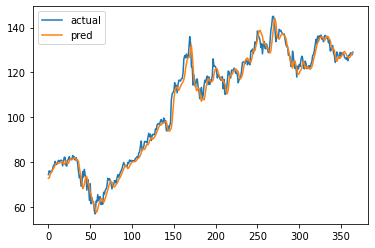

In [22]:
plt.plot(y_test_unscaled,label='actual')
plt.plot(y_pred,label='pred')
plt.legend()